In [9]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._


//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.7.1`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._



//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
     .master("local[*]")
    //.config("spark.executor.instances", "4") // Número de ejecutores
    //.config("spark.executor.memory", "4g") // Memoria por ejecutor
    //.config("spark.executor.cores", "2") // Núcleos por ejecutor
    //.config("spark.driver.memory", "4g") // Memoria del driver
    //.config("spark.sql.shuffle.partitions", "8") // Número de particiones para operaciones de shuffle
    .getOrCreate()
}
import spark.implicits._


val pathDatosConsulta2 = "../../data/parquet/DatosConsulta2.parquet"


val datosConsulta2: DataFrame = spark.read
  //.option("header", "true") // Si el archivo tiene un encabezado
  //.option("inferSchema", "true") // Para inferir automáticamente el esquema
  //.csv(filePath)
    .option("encoding", "UTF-8")
    .parquet(pathDatosConsulta2)


cmd9.sc:19: object graph_objects is not a member of package plotly
import plotly.graph_objects._
              ^Compilation Failed

: 

In [2]:
val filePath = "../../data/parquet/dsMercadoNacionalTotalPrueba.parquet"
val dataFrameMercados: DataFrame = spark.read
    .parquet(filePath)

val filePathBalance = "../../data/parquet/dsBalanceNacional11-24.parquet"  
val datosBalance: DataFrame = spark.read
    .parquet(filePathBalance)

parquet at cmd1.sc:3

1 / 1

parquet at cmd1.sc:7

1 / 1

filePath: String = "../../data/parquet/dsMercadoNacionalTotalPrueba.parquet"
dataFrameMercados: DataFrame = [Fecha: timestamp, Valor_Mercado_Spot: double ... 3 more fields]
filePathBalance: String = "../../data/parquet/dsBalanceNacional11-24.parquet"
datosBalance: DataFrame = [Familia: string, Tipo: string ... 5 more fields]

In [15]:
import org.apache.spark.sql.expressions.Window

val totalGlobal = datosBalance
    .filter(!$"Compuesto" && $"Familia" =!= "Demanda")
    .agg(sum($"Valor").as("TotalGlobal"))
    .collect()(0).getAs[Double]("TotalGlobal")

val ventanaOrdenada = Window.orderBy(desc("ValorTotal"))
val totalPorTipo = datosBalance
    .filter(!$"Compuesto" && $"Familia" =!= "Demanda")
    .groupBy($"Tipo")
    .agg(sum($"Valor").as("ValorTotal"))
    .orderBy(desc("ValorTotal"))
    .withColumn("Porcentaje (%)", round($"ValorTotal" / totalGlobal * 100, 2))
    .withColumn("Valor total", round($"ValorTotal"/1e6, 2))
    .withColumn(
        "Porcentaje acumulado (%)",
        round(sum($"Porcentaje (%)").over(ventanaOrdenada), 2))
    .select($"Tipo", $"Valor total", $"Porcentaje (%)", $"Porcentaje acumulado (%)")
    //.withColumn("Total", sum("ValorTotal"))
   
    //.withColumn("PorcentajeSobreTotal", round($"Valor" / $"TotalGenerado" * 100,2))
    
totalPorTipo.show()

collect at cmd14.sc:5

15 / 15

collect at cmd14.sc:5

1 / 1

show at cmd14.sc:24

15 / 15

show at cmd14.sc:24

200 / 200

show at cmd14.sc:24

200 / 200

show at cmd14.sc:24

17 / 17

show at cmd14.sc:24

1 / 1

+--------------------+-----------+--------------+------------------------+
|                Tipo|Valor total|Porcentaje (%)|Porcentaje acumulado (%)|
+--------------------+-----------+--------------+------------------------+
|             Nuclear|     767.26|          20.6|                    20.6|
|              Eólica|     741.53|         19.91|                   40.51|
|     Ciclo combinado|      562.6|         15.11|                   55.62|
|          Hidráulica|     406.05|          10.9|                   66.52|
|              Carbón|     388.97|         10.45|                   76.97|
|        Cogeneración|     359.68|          9.66|                   86.63|
|  Solar fotovoltaica|     218.44|          5.87|                    92.5|
|       Solar térmica|      61.92|          1.66|                   94.16|
|    Otras renovables|      54.25|          1.46|                   95.62|
|  Turbinación bombeo|      43.58|          1.17|                   96.79|
|      Motores diésel|   

import org.apache.spark.sql.expressions.Window


totalGlobal: Double = 3.723835654957E9
ventanaOrdenada: expressions.WindowSpec = org.apache.spark.sql.expressions.WindowSpec@56233e3b
totalPorTipo: DataFrame = [Tipo: string, Valor total: double ... 2 more fields]

In [22]:
val mercadoDiario = dfMercados
            .groupBy(date_format(col("Fecha"),"yyyy-MM-dd").as("FechaDia"))
            .agg(avg("Valor_Mercado_Spot").as("ValorMercadoSpot"))
            .withColumn("PrecioMercado_€", round(col("ValorMercadoSpot"), 2))
            .drop("ValorMercadoSpot")
mercadoDiario.show()

show at cmd21.sc:6

15 / 15

show at cmd21.sc:6

15 / 15

show at cmd21.sc:6

200 / 200

show at cmd21.sc:6

1 / 1

+----------+---------------+
|  FechaDia|PrecioMercado_€|
+----------+---------------+
|2014-02-16|          23.01|
|2014-02-22|          18.37|
|2014-05-27|          49.16|
|2014-12-13|          45.95|
|2015-05-01|          39.12|
|2016-08-17|          43.35|
|2017-05-14|          44.21|
|2017-12-05|          76.54|
|2019-08-08|          47.56|
|2019-08-22|          40.97|
|2019-08-23|          41.53|
|2020-02-26|          31.97|
|2020-04-13|          22.52|
|2021-11-03|         154.29|
|2022-10-05|         162.89|
|2023-01-21|          58.89|
|2023-05-01|          61.41|
|2023-05-18|           52.2|
|2024-01-19|          70.87|
|2024-07-14|          51.54|
+----------+---------------+
only showing top 20 rows



mercadoDiario: DataFrame = [FechaDia: string, PrecioMercado_€: double]

In [23]:
val top7Energias = datosBalance
            .filter($"Compuesto" === false)
            .filter($"Familia" =!= "Demanda")
            .groupBy($"Tipo")
            .agg(sum($"Valor").as("ValorTotal"))
            .withColumn("Valor total millones MWh", round(col("ValorTotal") / 1e6, 2))
            .orderBy(desc("Valor total millones MWh"))
            .limit(7)
            .select($"Tipo")
            .as[String]
            .collect
            .toSeq 

collect at cmd22.sc:10

15 / 15

collect at cmd22.sc:10

200 / 200

top7Energias: Seq[String] = WrappedArray(
  "Nuclear",
  "E\u00f3lica",
  "Ciclo combinado",
  "Hidr\u00e1ulica",
  "Carb\u00f3n",
  "Cogeneraci\u00f3n",
  "Solar fotovoltaica"
)

In [30]:
val dfBalanceFiltrado = datosBalance 
            .filter($"Tipo".isin(top7Energias: _*))
            .withColumn("FechaDia", date_format(col("Fecha"), "yyyy-MM-dd")) // Extraer solo la parte del día

// // Calcular el porcentaje diario de cada tipo de energía
val windowTotal = Window.partitionBy("FechaDia") // Ventana para agrupar por día

val dfBalanceConPorcentajeTotal = dfBalanceFiltrado
    .withColumn("GeneracionTotalDiaria", sum("Valor").over(windowTotal)) // Total de generación por cada día
    .withColumn("PorcentajeRespectoTotal", round((col("Valor") / col("GeneracionTotalDiaria")) * 100, 2)) //Calcular porcentaje
    .select("FechaDia", "Tipo", "Familia", "Valor", "PorcentajeRespectoTotal") //Selectiono las columnas relevantes

dfBalanceConPorcentajeTotal.show()

show at cmd29.sc:13

15 / 15

show at cmd29.sc:13

1 / 1

+----------+------------------+------------+----------+-----------------------+
|  FechaDia|              Tipo|     Familia|     Valor|PorcentajeRespectoTotal|
+----------+------------------+------------+----------+-----------------------+
|2011-01-29|        Hidráulica|   Renovable|150659.269|                  19.88|
|2011-01-29|            Eólica|   Renovable| 81389.835|                  10.74|
|2011-01-29|Solar fotovoltaica|   Renovable|  9929.075|                   1.31|
|2011-01-29|           Nuclear|No-Renovable|140675.006|                  18.56|
|2011-01-29|   Ciclo combinado|No-Renovable| 228301.66|                  30.13|
|2011-01-29|            Carbón|No-Renovable| 68850.485|                   9.09|
|2011-01-29|      Cogeneración|No-Renovable| 77940.386|                  10.29|
|2013-03-14|        Hidráulica|   Renovable|167466.941|                  20.76|
|2013-03-14|            Eólica|   Renovable|237151.152|                   29.4|
|2013-03-14|Solar fotovoltaica|   Renova

dfBalanceFiltrado: DataFrame = [Familia: string, Tipo: string ... 6 more fields]
windowTotal: expressions.WindowSpec = org.apache.spark.sql.expressions.WindowSpec@42751310
dfBalanceConPorcentajeTotal: DataFrame = [FechaDia: string, Tipo: string ... 3 more fields]

In [28]:
val dfBalancePivotadoTipo = dfBalanceConPorcentajeTotal
    .groupBy("FechaDia")
    .pivot("Tipo")
    .agg(first("PorcentajeRespectoTotal").as("%"), first("Valor").as("MWh"))

dfBalancePivotadoTipo.show()

pivot at cmd27.sc:3

15 / 15

pivot at cmd27.sc:3

200 / 200

pivot at cmd27.sc:3

1 / 1

show at cmd27.sc:5

15 / 15

show at cmd27.sc:5

1 / 1

+----------+--------+----------+-----------------+-------------------+--------------+----------------+--------+----------+------------+--------------+---------+-----------+--------------------+----------------------+
|  FechaDia|Carbón_%|Carbón_MWh|Ciclo combinado_%|Ciclo combinado_MWh|Cogeneración_%|Cogeneración_MWh|Eólica_%|Eólica_MWh|Hidráulica_%|Hidráulica_MWh|Nuclear_%|Nuclear_MWh|Solar fotovoltaica_%|Solar fotovoltaica_MWh|
+----------+--------+----------+-----------------+-------------------+--------------+----------------+--------+----------+------------+--------------+---------+-----------+--------------------+----------------------+
|2011-01-29|    9.09| 68850.485|            30.13|          228301.66|         10.29|       77940.386|   10.74| 81389.835|       19.88|    150659.269|    18.56| 140675.006|                1.31|              9929.075|
|2013-03-14|    4.59|  37027.26|             8.09|          65291.804|         12.41|      100106.852|    29.4|237151.152|       20.

dfBalancePivotadoTipo: DataFrame = [FechaDia: string, Carbón_%: double ... 13 more fields]

In [31]:
val unionMercadosBalance = mercadoDiario.join(dfBalancePivotadoTipo, Seq("FechaDia"), "inner")

unionMercadosBalance: DataFrame = [FechaDia: string, PrecioMercado_€: double ... 14 more fields]

In [32]:
unionMercadosBalance.show()

run at ThreadPoolExecutor.java:1149

15 / 15

run at ThreadPoolExecutor.java:1149

15 / 15

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

show at cmd31.sc:1

15 / 15

show at cmd31.sc:1

1 / 1

+----------+---------------+--------+----------+-----------------+-------------------+--------------+----------------+--------+----------+------------+--------------+---------+-----------+--------------------+----------------------+
|  FechaDia|PrecioMercado_€|Carbón_%|Carbón_MWh|Ciclo combinado_%|Ciclo combinado_MWh|Cogeneración_%|Cogeneración_MWh|Eólica_%|Eólica_MWh|Hidráulica_%|Hidráulica_MWh|Nuclear_%|Nuclear_MWh|Solar fotovoltaica_%|Solar fotovoltaica_MWh|
+----------+---------------+--------+----------+-----------------+-------------------+--------------+----------------+--------+----------+------------+--------------+---------+-----------+--------------------+----------------------+
|2014-02-16|          23.01|    4.46| 27920.502|             8.79|          55033.705|          8.32|       52104.606|   10.88| 68173.549|       37.55|    235188.511|    27.32| 171152.861|                2.69|             16820.627|
|2014-02-22|          18.37|    4.09| 27664.697|              6.1|  

In [3]:
val pathDatosConsulta2 = "../../data/parquet/DatosConsulta2.parquet"


val datosConsulta2: DataFrame = spark.read
  //.option("header", "true") // Si el archivo tiene un encabezado
  //.option("inferSchema", "true") // Para inferir automáticamente el esquema
  //.csv(filePath)
    .option("encoding", "UTF-8")
    .parquet(pathDatosConsulta2)

parquet at cmd2.sc:9

1 / 1

pathDatosConsulta2: String = "../../data/parquet/DatosConsulta2.parquet"
datosConsulta2: DataFrame = [FechaDia: string, PrecioMercado: double ... 14 more fields]

In [4]:
datosConsulta2.show()

show at cmd3.sc:1

1 / 1

+----------+-------------+--------+----------+-----------------+-------------------+--------------+----------------+--------+----------+------------+--------------+---------+-----------+--------------------+----------------------+
|  FechaDia|PrecioMercado|Carbón_%|Carbón_MWh|Ciclo_combinado_%|Ciclo_combinado_MWh|Cogeneración_%|Cogeneración_MWh|Eólica_%|Eólica_MWh|Hidráulica_%|Hidráulica_MWh|Nuclear_%|Nuclear_MWh|Solar_fotovoltaica_%|Solar_fotovoltaica_MWh|
+----------+-------------+--------+----------+-----------------+-------------------+--------------+----------------+--------+----------+------------+--------------+---------+-----------+--------------------+----------------------+
|2014-01-01|         5.69|    4.09| 25240.655|             8.67|            53534.6|          8.75|       54043.077|   41.77|257896.205|       11.83|     73065.052|    23.65| 146015.503|                1.24|              7631.801|
|2014-01-02|        24.59|    5.53| 37546.113|             7.71|          52

collect at cmd12.sc:11

1 / 1

collect at cmd12.sc:11

200 / 200

collect at cmd12.sc:11

200 / 200

collect at cmd12.sc:11

132 / 132

collect at cmd12.sc:12

1 / 1

collect at cmd12.sc:12

200 / 200

collect at cmd12.sc:12

200 / 200

collect at cmd12.sc:12

132 / 132

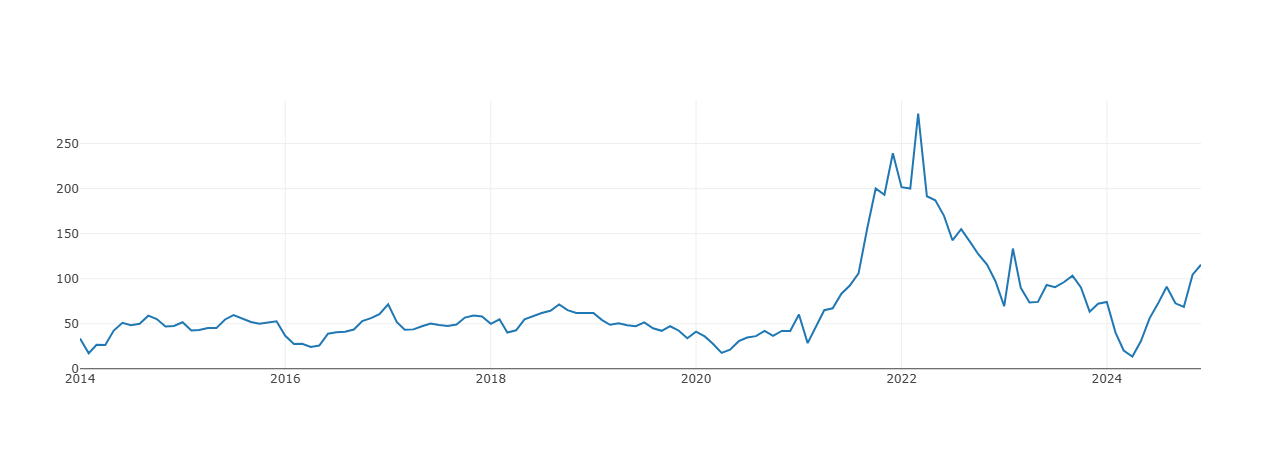

defined function analisisPrecioMensual

In [13]:
def analisisPrecioMensual (df: DataFrame): Unit = {
    //Calculamos la generacion total por año
    val evolucionPrecio = df
      .select($"FechaDia", $"PrecioMercado")
      .groupBy(date_format(col("FechaDia"), "yyyy-MM").as("FechaMes"))
      .agg(avg("PrecioMercado").as("Media_mensual_€"))
      .orderBy($"FechaMes")
    
    
    //Pintamos la gráfica
    val fechas = evolucionPrecio.select("FechaMes").as[String].collect.toSeq
    val precioMensual = evolucionPrecio.select("Media_mensual_€").as[Double].collect.toSeq
    val evolucionMercadosMensualmente = Scatter(fechas, precioMensual, name = "Precio Mercados en €")

    val data = Seq(evolucionMercadosMensualmente)
    
    plot(data)
    
}
analisisPrecioMensual(datosConsulta2)

In [12]:
def calcularCorrelaciones(df: DataFrame, precioColumna: String): DataFrame = {
    // Filtrar columnas relevantes (las que terminan con "_%" o "_MWh")
    val columnasEnergia = df.columns.filter(col => col.endsWith("_%") || col.endsWith("_MWh"))

    // Calcular correlación para cada columna de energía
    val correlaciones = columnasEnergia.map { colEnergia =>
        val correlacion = df.stat.corr(precioColumna, colEnergia) // Calcular correlación
        (colEnergia, correlacion) // Devolver columna y correlación
    }

    // Convertir a DataFrame para ordenarlo y mostrarlo
    import spark.implicits._
    correlaciones.toSeq.toDF("Energía", "Correlación").orderBy(desc("Correlación"))
}

// Llamar a la función para calcular las correlaciones
val resultadoCorrelaciones = calcularCorrelaciones(datosConsulta2, "PrecioMercado_€")
resultadoCorrelaciones.show()


corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

show at cmd11.sc:18

14 / 14

+--------------------+--------------------+
|             Energía|         Correlación|
+--------------------+--------------------+
| Ciclo_combinado_MWh|  0.5112746442572531|
|   Ciclo_combinado_%| 0.49218935745748954|
|Solar_fotovoltaic...|  0.2924628212691979|
|Solar_fotovoltaica_%|  0.2629925493953789|
|         Nuclear_MWh|0.027181711226881945|
|          Eólica_MWh|-0.08305614302342378|
|           Nuclear_%|-0.09493220327086346|
|    Cogeneración_MWh|-0.12271759590501925|
|            Eólica_%|-0.12568609916427367|
|          Carbón_MWh|-0.18132259474230716|
|      Cogeneración_%|-0.18327962958232394|
|            Carbón_%| -0.1946874392238486|
|      Hidráulica_MWh| -0.2891542535476879|
|        Hidráulica_%|-0.32012965511957897|
+--------------------+--------------------+



defined function calcularCorrelaciones
resultadoCorrelaciones: DataFrame = [Energía: string, Correlación: double]

In [37]:
def graficoAreasApiladas(datosConsulta2: DataFrame): Unit = {
    
    val df = datosConsulta2.filter(date_format($"FechaDia", "yyyy-MM").isin("2024-12"))
                          
    // Extraer las fechas (eje X)
    val fechas = df.select("FechaDia").as[String].collect.toSeq

    // Extraer valores para cada tipo de generación (eje Y)
    val carbon = df.select("Carbón_MWh").as[Double].collect.toSeq
    val cicloCombinado = df.select("Ciclo_combinado_MWh").as[Double].collect.toSeq
    val cogeneracion = df.select("Cogeneración_MWh").as[Double].collect.toSeq
    val eolica = df.select("Eólica_MWh").as[Double].collect.toSeq
    val nuclear = df.select("Nuclear_MWh").as[Double].collect.toSeq
    val hidraulica = df.select("Hidráulica_MWh").as[Double].collect.toSeq
    val solar = df.select("Solar_fotovoltaica_MWh").as[Double].collect.toSeq
   
    
    //Extraer valores precio
    val precioEnergia = df.select("PrecioMercado").as[Double].collect.toSeq
    
    // Crear las trazas para cada fuente de energía
    val traceCarbon = Scatter(fechas, carbon, name = "Carbón", stackgroup = "1", fill = Fill.ToNextY)
    val traceCicloCombinado = Scatter(fechas, cicloCombinado, name = "Ciclo Combinado", stackgroup = "1", fill = Fill.ToNextY)
    val traceEolica = Scatter(fechas, eolica, name = "Eólica", stackgroup = "1", fill = Fill.ToNextY)
    val traceHidraulica = Scatter(fechas, hidraulica, name = "Hidráulica", stackgroup = "1", fill = Fill.ToNextY)
    val traceNuclear = Scatter(fechas, nuclear, name = "Nuclear", stackgroup = "1", fill = Fill.ToNextY)
    val traceSolar = Scatter(fechas, solar, name = "Solar Fotovoltaica", stackgroup = "1", fill = Fill.ToNextY)
    val traceCogeneracion = Scatter(fechas, cogeneracion, name = "Cogeneración", stackgroup = "1", fill = Fill.ToNextY)
    
    //Crear la traza del precio de energia
    val tracePrecioEnergia = Scatter(fechas, precioEnergia, name = "Precio Mercados en €",yaxis = AxisReference.Y2)
    

    // Configurar el diseño del gráfico
    val layout = Layout(
        title = "Generación de Energía por Tipo (Áreas Apiladas)",
        xaxis = Axis(title = "Fecha"),
        yaxis = Axis(title = "Energía Generada (MWh)"),
        yaxis2 = Axis(
          title = "Precio Energía (€)",
          overlaying = AxisAnchor.Y, // Superponer sobre el eje Y principal
          side = Side.Right // Posicionar en el lado derecho
        ),
        showlegend = true
    )

    // Agrupar todas las trazas
    val data = Seq(traceHidraulica, traceSolar,traceNuclear,traceEolica, tracePrecioEnergia, traceCicloCombinado, traceCogeneracion, traceCarbon)
    // Renderizar el gráfico
    plot(data, layout)
    
}


defined function graficoAreasApiladas

collect at cmd36.sc:6

1 / 1

collect at cmd36.sc:9

1 / 1

collect at cmd36.sc:10

1 / 1

collect at cmd36.sc:11

1 / 1

collect at cmd36.sc:12

1 / 1

collect at cmd36.sc:13

1 / 1

collect at cmd36.sc:14

1 / 1

collect at cmd36.sc:15

1 / 1

collect at cmd36.sc:19

1 / 1

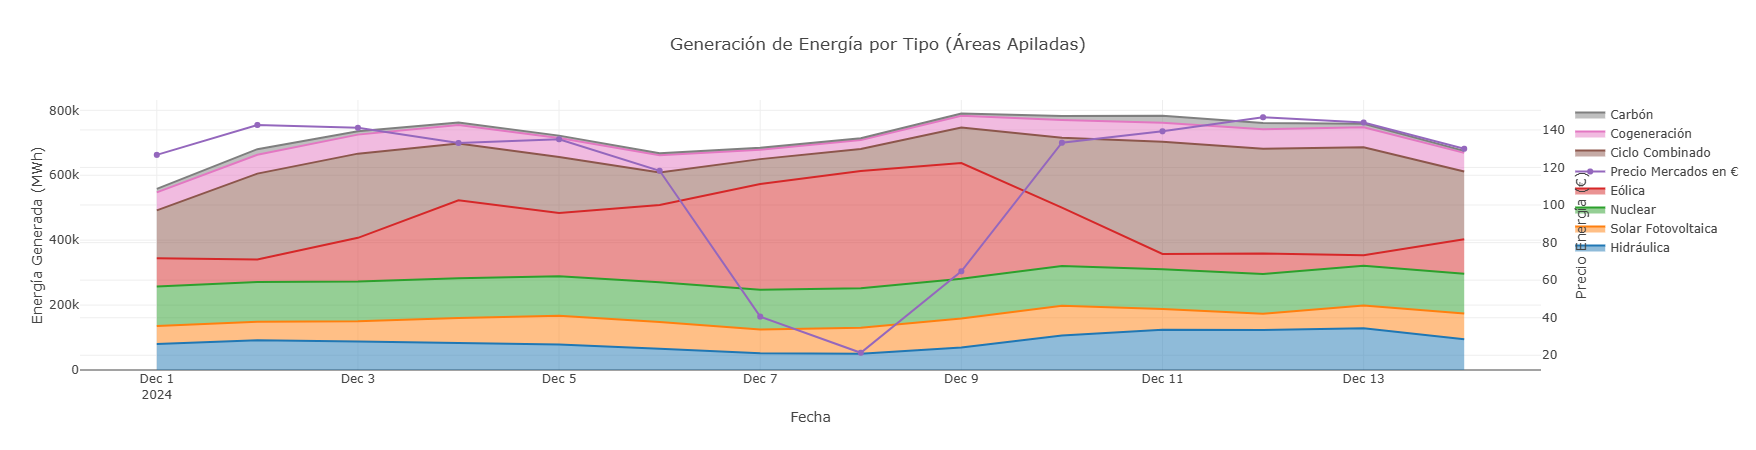

In [38]:
graficoAreasApiladas(datosConsulta2)

In [11]:
TwoAxesExample

res10: TwoAxesExample.type = ammonite.$sess.cmd9$Helper$TwoAxesExample$@2a1c2f19